In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from losses import get_loss_f
from train import Trainer

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, Attributer, get_2dfilts, initialize_filters
from utils import tuple_L1Loss, tuple_L2Loss, thresh_attrs, viz_list
from pytorch_wavelets import DTCWTForward, DTCWTInverse, DWTForward, DWTInverse
import pywt

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

## initialize filter

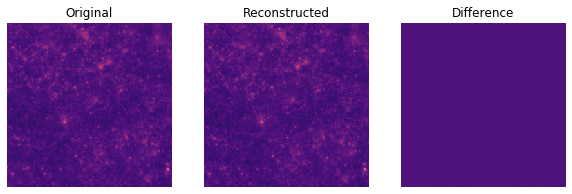

Recon=0.00000


In [3]:
# wavelet transform with initialization
wt_orig = Wavelet_Transform(wt_type='DWT', wave='db3', mode='symmetric', device='cuda', J=5)
viz_im_r(im[0], wt_orig.inverse(wt_orig(im))[0])
print("Recon={:.5f}".format(torch.norm(wt_orig.inverse(wt_orig(im)) - im)**2/im.size(0)))

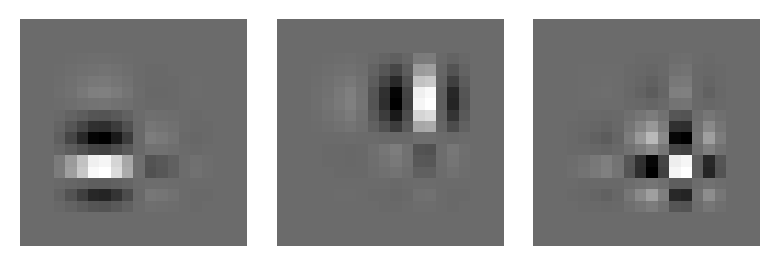

In [5]:
filt = get_2dfilts(wt_orig)
viz_list(filt, figsize=(4,4))

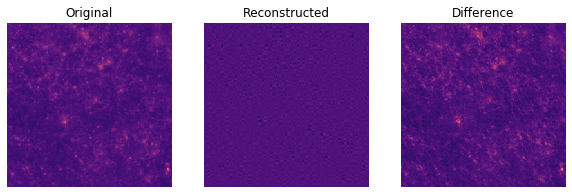

Recon=25.34073


In [12]:
wt = initialize_filters(wt_orig, init_level=0, noise_level=0.5)
filt = get_2dfilts(wt)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

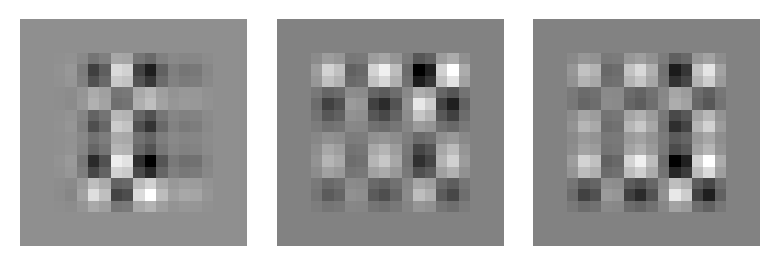

In [13]:
viz_list(filt, figsize=(4,4))

## optimize filter

In [ ]:
# train
params = list(wt.xfm.parameters()) + list(wt.ifm.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
loss_f = get_loss_f(lamL1attr=0, lamL1Maxattr=0)
trainer = Trainer(model, wt, Attributer, optimizer, loss_f, device=device)
trainer(train_loader, epochs=50)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 4.209517
====> Epoch: 0 Average train loss: 13.8899
Train Epoch: 1 [18816/25000 (75%)]	Loss: 2.095444

In [ ]:
filt = get_2dfilts(wt_orig)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt.inverse(wt(im)) - im)**2/im.size(0)))

In [ ]:
viz_list(filt, figsize=(4,4))